In [1]:
import os

import torch
from PIL import Image
import requests
from torch.utils.data import Dataset

from transformers import CLIPProcessor, CLIPModel


def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def find_matches(model, image, text, processor, device):
    """
    计算图片与文本的相似度

    Args:
        model: CLIP 模型
        image: 图片
        text: 文本
        processor: CLIP 处理器

    Returns:
        max_prob_index: 概率最大的标签
    """

    inputs = processor(text=text, images=image,
                       return_tensors="pt", padding=True)  # type: ignore
    # 将输入数据移动到指定设备
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor)
              else v for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        # this is the image-text similarity score
        logits_per_image = outputs.logits_per_image
        # we can take the softmax to get the label probabilities
        probs = logits_per_image.softmax(dim=1)
        # 获取概率最大的标签
        max_prob_index = torch.argmax(probs, dim=1)
        return max_prob_index


def get_image_embeddings(model, images, processor, device):
    """
    计算批量图片的 embedding

    Args:
        model: CLIP 模型
        images: 图片列表
        processor: CLIP 处理器

    Returns:
        image_embeddings: 图片的 embedding 向量
    """
    # 处理图片
    inputs = processor(images=images, return_tensors="pt", padding=True)
    # 将输入数据移动到指定设备
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor)
              else v for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        # 获取图片特征
        image_features = model.get_image_features(**inputs)
        # 归一化
        image_embeddings = image_features / \
            image_features.norm(dim=-1, keepdim=True)

    return image_embeddings


def get_text_embeddings(model, text, processor, device):
    inputs = processor(text=text, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor)
              else v for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / \
            text_features.norm(dim=-1, keepdim=True)
    return text_features


class ImageDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.images = [f for f in os.listdir(
            root) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 处理切片操作
        if isinstance(idx, slice):
            start = idx.start if idx.start is not None else 0
            stop = idx.stop if idx.stop is not None else len(self)
            stop = min(stop, len(self))
            step = idx.step if idx.step is not None else 1
            return [self._load_image(i) for i in range(start, stop, step)]
        # 处理单个索引
        return self._load_image(idx)

    def _load_image(self, idx):
        image_path = os.path.join(self.root, self.images[idx])
        image = Image.open(image_path)
        return image


device = get_device()
model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32").to(device)  # type: ignore
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/Users/apple/Desktop/python/dh_ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/apple/Desktop/python/dh_ai/.venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
import time

from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

current_dir = Path.cwd()  # 获取当前工作目录
image_dir = Path(current_dir).parent / \
    '代码实现/datasets/all_images'

# 分批读取 val2017 文件夹下的所有图片
dataset = ImageDataset(root=image_dir)
batch_size = 512
start_time = time.time()
all_image_embeddings = []

progress_bar = tqdm(range(0, len(dataset), batch_size))
for i in progress_bar:
    batch_imgs = dataset[i:i+batch_size]
    image_embeddings = get_image_embeddings(
        model, batch_imgs, processor, device)
    all_image_embeddings.append(image_embeddings)

all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

Time taken: 50.36969876289368 seconds


query is:  a car driving on the road


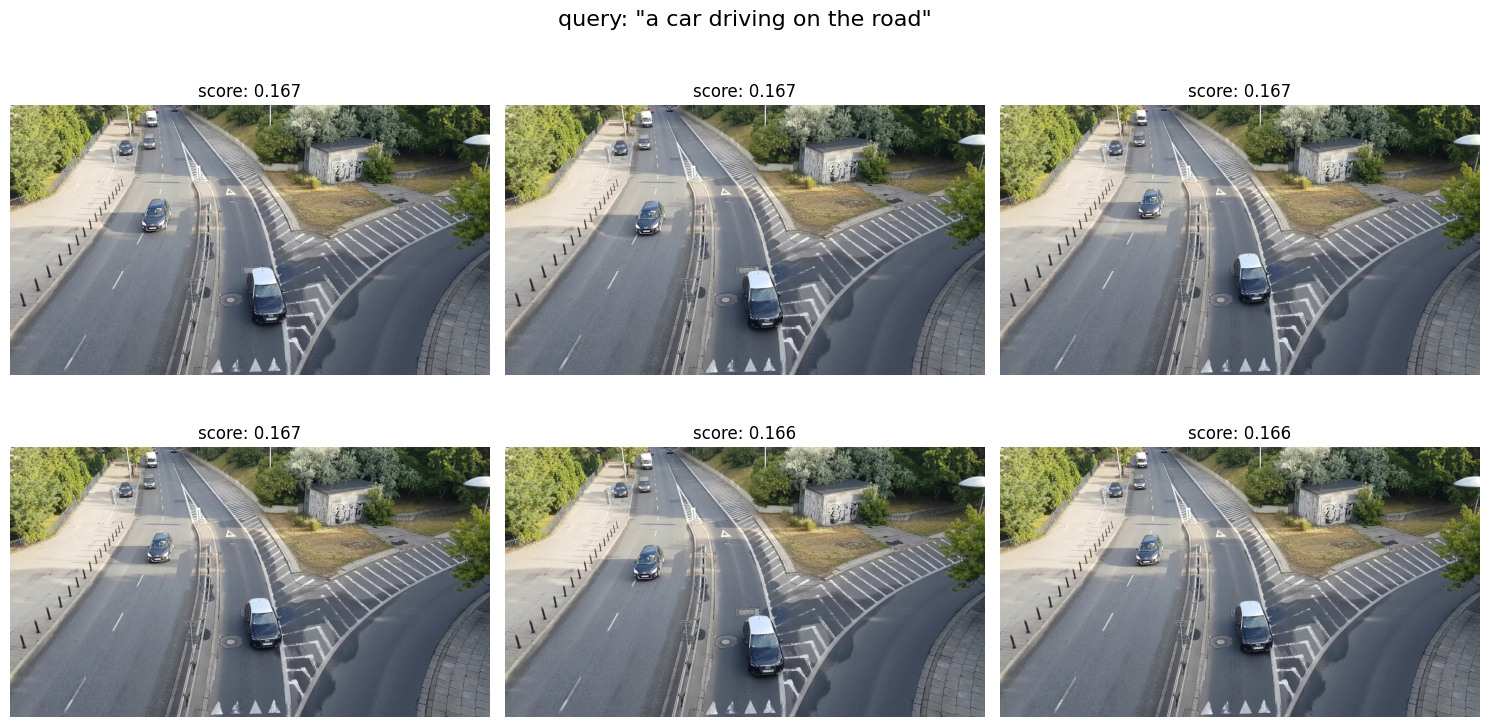

In [3]:
import matplotlib.pyplot as plt


def search_images(model, query, all_image_embeddings, processor, top_n, device):
    text_features = get_text_embeddings(model, query, processor, device)
    logits_per_image = torch.matmul(text_features, all_image_embeddings.T)
    values, indices = logits_per_image[0].topk(top_n)
    values = values.softmax(dim=0)
    return values, indices.cpu().numpy()


def plot_similar_images(dataset, indices, values, query_text):
    plt.figure(figsize=(15, 8))
    print('query is: ', query_text)
    for idx, (img_idx, similarity) in enumerate(zip(indices, values)):
        plt.subplot(2, 3, idx + 1)
        img = dataset[img_idx]
        plt.imshow(img)
        plt.title(f'score: {similarity:.3f}')
        plt.axis('off')
    plt.suptitle(f'query: "{query_text}"', fontsize=16)
    plt.tight_layout()
    plt.show()


# 使用示例：
top_n = 6
query_list = [
    'a photo of dog',
    'a photo of cat, type of animal',
    'a photo of people laugh loudly',
    'a photo of people working in the office',
    'a photo of traffic, many cars across the road',
    'a photo of child playing outside'
]
# query_text = query_list[5]
query_text = 'a car driving on the road'
values, indices = search_images(
    model, query_text, all_image_embeddings, processor, top_n, device)

# 绘制 top_n 个最相似的 PIL 图片
plot_similar_images(dataset, indices, values, query_text)